In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from napkinxc.datasets import load_dataset
from napkinxc.models import PLT
from napkinxc.metrics import precision_at_k, ndcg_at_k, psdcg_at_k

def compute_inv_ps(Y):
    if isinstance(Y, list):
        all_labels = set()
        for labels in Y:
            all_labels.update(labels)
        num_labels = max(all_labels) + 1 if all_labels else 0
        num_samples = len(Y)
        Y_dense = np.zeros((num_samples, num_labels), dtype=np.float32)
        for i, labels in enumerate(Y):
            Y_dense[i, labels] = 1
        Y = Y_dense
    elif hasattr(Y, 'toarray'):
        Y = Y.toarray()
    else:
        Y = np.asarray(Y, dtype=np.float32)

    counts = np.sum(Y, axis=0)
    counts = np.where(counts == 0, 1, counts)
    inv_ps = 1.0 / np.log1p(counts)
    return inv_ps

class ExtendedPLT(PLT):
    def __init__(self, name):
        super().__init__(name)

    def fit(self, X, Y):
        super().fit(X, Y)

    def fit_for_adversarial_examples(self, X, Y, noise_level=0.05, augment_ratio=1.0):
        num_samples = X.shape[0]
        num_augment = int(num_samples * augment_ratio)
        X_noisy = X.copy()[:num_augment] + np.random.normal(0, noise_level, (num_augment, X.shape[1]))

        if hasattr(X, 'toarray'):
            X_combined = np.vstack([X.toarray(), X_noisy])
        else:
            X_combined = np.vstack([X, X_noisy])

        if isinstance(Y, list):
            Y_combined = Y + Y[:num_augment]
        elif hasattr(Y, 'toarray'):
            Y_combined = np.vstack([Y.toarray(), Y.toarray()[:num_augment]])
        else:
            Y_combined = np.vstack([Y, Y[:num_augment]])

        super().fit(X_combined, Y_combined)

    def explain(self, X_instance, top_features=5):
        if hasattr(X_instance, 'toarray'):
            X_instance = X_instance.toarray().flatten()
        feature_values = X_instance
        abs_values = np.abs(feature_values)
        top_idx = np.argsort(abs_values)[-top_features:][::-1]
        top_values = feature_values[top_idx]
        return list(zip(top_idx, top_values))

    def adversarial_evaluation(self, X, Y, inv_ps, noise_levels, k_values):
        results = {k: {} for k in k_values}
        for k in k_values:
            for noise in noise_levels:
                print(f"  > Evaluating with noise level: {noise}, k={k}")
                start_pred = time.time()
                X_noisy = X.copy() + np.random.normal(0, noise, X.shape)
                Y_pred = self.predict(X_noisy, top_k=k)
                pred_time = time.time() - start_pred
                p_at_k = np.mean(precision_at_k(Y, Y_pred, k=k))
                dcg = np.mean(ndcg_at_k(Y, Y_pred, k=k))
                psdcg = np.mean(psdcg_at_k(Y, Y_pred, inv_ps, k=k))
                results[k][noise] = {
                    "P@k": p_at_k,
                    "nDCG@k": dcg,
                    "PSDCG@k": psdcg,
                    "PredictionTime": pred_time
                }
                print(f"    Metrics -> Precision@{k}: {p_at_k:.4f}, nDCG@{k}: {dcg:.4f}, PSDCG@{k}: {psdcg:.4f}")
                print(f"    Prediction Time: {pred_time:.4f} seconds")
        return results

def plot_performance_metrics(adv_results_normal, adv_results_adv, base_metrics_normal, base_metrics_adv, dataset_name, k_values):
    noise_levels = [0] + sorted([n for k in adv_results_normal for n in adv_results_normal[k]])
    noise_levels = sorted(list(set(noise_levels)))

    plt.figure(figsize=(12, 6))
    for k in k_values:
        values_normal = [base_metrics_normal[k]["P@k"] if noise == 0 else adv_results_normal[k][noise]["P@k"]
                         for noise in noise_levels if noise == 0 or noise in adv_results_normal[k]]
        values_adv = [base_metrics_adv[k]["P@k"] if noise == 0 else adv_results_adv[k][noise]["P@k"]
                      for noise in noise_levels if noise == 0 or noise in adv_results_adv[k]]
        plt.plot(noise_levels, values_normal, marker='o', linestyle='-', label=f'Precision@{k} (Normal)')
        plt.plot(noise_levels, values_adv, marker='s', linestyle='--', label=f'Precision@{k} (Adversarial)')
    plt.xlabel('Noise Level')
    plt.ylabel('Precision@k')
    plt.title(f'Precision@k vs. Noise Levels for {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    for k in k_values:
        values_normal = [base_metrics_normal[k]["nDCG@k"] if noise == 0 else adv_results_normal[k][noise]["nDCG@k"]
                         for noise in noise_levels if noise == 0 or noise in adv_results_normal[k]]
        values_adv = [base_metrics_adv[k]["nDCG@k"] if noise == 0 else adv_results_adv[k][noise]["nDCG@k"]
                      for noise in noise_levels if noise == 0 or noise in adv_results_adv[k]]
        plt.plot(noise_levels, values_normal, marker='o', linestyle='-', label=f'nDCG@{k} (Normal)')
        plt.plot(noise_levels, values_adv, marker='s', linestyle='--', label=f'nDCG@{k} (Adversarial)')
    plt.xlabel('Noise Level')
    plt.ylabel('nDCG@k')
    plt.title(f'nDCG@k vs. Noise Levels for {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    for k in k_values:
        values_normal = [base_metrics_normal[k]["PSDCG@k"] if noise == 0 else adv_results_normal[k][noise]["PSDCG@k"]
                         for noise in noise_levels if noise == 0 or noise in adv_results_normal[k]]
        values_adv = [base_metrics_adv[k]["PSDCG@k"] if noise == 0 else adv_results_adv[k][noise]["PSDCG@k"]
                      for noise in noise_levels if noise == 0 or noise in adv_results_adv[k]]
        plt.plot(noise_levels, values_normal, marker='o', linestyle='-', label=f'PSDCG@{k} (Normal)')
        plt.plot(noise_levels, values_adv, marker='s', linestyle='--', label=f'PSDCG@{k} (Adversarial)')
    plt.xlabel('Noise Level')
    plt.ylabel('PSDCG@k')
    plt.title(f'PSDCG@k vs. Noise Levels for {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_prediction_time(adv_results_normal, adv_results_adv, base_metrics_normal, base_metrics_adv, dataset_name, k_values):
    noise_levels = [0] + sorted([n for k in adv_results_normal for n in adv_results_normal[k]])
    noise_levels = sorted(list(set(noise_levels)))

    plt.figure(figsize=(12, 6))
    for k in k_values:
        values_normal = [base_metrics_normal[k]["PredictionTime"] if noise == 0 else adv_results_normal[k][noise]["PredictionTime"]
                         for noise in noise_levels if noise == 0 or noise in adv_results_normal[k]]
        values_adv = [base_metrics_adv[k]["PredictionTime"] if noise == 0 else adv_results_adv[k][noise]["PredictionTime"]
                      for noise in noise_levels if noise == 0 or noise in adv_results_adv[k]]
        plt.plot(noise_levels, values_normal, marker='o', linestyle='-', label=f'k={k} (Normal)')
        plt.plot(noise_levels, values_adv, marker='s', linestyle='--', label=f'k={k} (Adversarial)')
    plt.xlabel('Noise Level')
    plt.ylabel('Prediction Time (seconds)')
    plt.title(f'Prediction Time vs. Noise Levels for {dataset_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_feature_importance(explanation, dataset_name, model_type="Normal"):
    if not explanation or not isinstance(explanation[0], (tuple, list)):
        print(f"Warning: Invalid explanation format for {dataset_name} ({model_type}). Expected list of (index, value) tuples, got {type(explanation)}. Skipping plot.")
        return
    try:
        indices, values = zip(*explanation)
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(indices)), values, tick_label=indices)
        plt.xlabel('Feature Index')
        plt.ylabel('Feature Value')
        plt.title(f'Top Features for First Test Instance in {dataset_name} ({model_type})')
        plt.show()
    except Exception as e:
        print(f"Error plotting feature importance for {dataset_name} ({model_type}): {e}")

def plot_noise_impact(X_samples, noise_levels, dataset_name, num_features=10):
    num_samples = min(X_samples.shape[0], 3)
    for sample_idx in range(num_samples):
        if hasattr(X_samples, 'toarray'):
            x_clean = X_samples[sample_idx].toarray().flatten()
        else:
            x_clean = X_samples[sample_idx].flatten()

        abs_values = np.abs(x_clean)
        top_indices = np.argsort(abs_values)[-num_features:][::-1]
        x_clean_subset = x_clean[top_indices]

        x_noisy_versions = []
        for noise in noise_levels:
            noise_array = np.random.normal(0, noise, x_clean.shape)
            x_noisy = x_clean + noise_array
            x_noisy_subset = x_noisy[top_indices]
            x_noisy_versions.append(x_noisy_subset)

        fig, ax = plt.subplots(figsize=(12, 6))
        bar_width = 0.2
        index = np.arange(num_features)

        ax.bar(index - 1.5 * bar_width, x_clean_subset, bar_width, label='Clean', color='blue')

        colors = ['orange', 'green', 'red']
        for i, (noise, x_noisy_subset) in enumerate(zip(noise_levels, x_noisy_versions)):
            ax.bar(index + (i - 1) * bar_width, x_noisy_subset, bar_width, label=f'Noise={noise}', color=colors[i])

        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Feature Value')
        ax.set_title(f'Noise Impact on Sample {sample_idx + 1} for {dataset_name}')
        ax.set_xticks(index)
        ax.set_xticklabels(top_indices, rotation=45)
        ax.legend()
        plt.tight_layout()
        plt.show()

def run_experiment(dataset_name):
    print("\n===========================================")
    print(f"Experiment for Dataset: {dataset_name}")
    print("===========================================")

    print("Loading data...")
    try:
        X_train, Y_train = load_dataset(dataset_name, "train")
        X_test, Y_test = load_dataset(dataset_name, "test")
    except Exception as e:
        print(f"Failed to load dataset {dataset_name}: {e}")
        return
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

    print("Computing inverse propensity scores...")
    inv_ps = compute_inv_ps(Y_train)

    k_values = [1, 3, 5]
    noise_levels = [0.01, 0.05, 0.1]

    model_normal_name = f"{dataset_name}-extended-plt-normal"
    model_normal = ExtendedPLT(model_normal_name)
    print("\nStarting normal training...")
    start_train = time.time()
    model_normal.fit(X_train, Y_train)
    train_time_normal = time.time() - start_train
    print(f"Normal training completed in {train_time_normal:.4f} seconds")

    model_adv_name = f"{dataset_name}-extended-plt-adversarial"
    model_adv = ExtendedPLT(model_adv_name)
    print("\nStarting adversarial training...")
    start_train = time.time()
    model_adv.fit_for_adversarial_examples(X_train, Y_train, noise_level=0.05, augment_ratio=1.0)
    train_time_adv = time.time() - start_train
    print(f"Adversarial training completed in {train_time_adv:.4f} seconds")

    base_metrics_normal = {}
    base_metrics_adv = {}
    print("\nPredicting on clean test data...")

    print("\nNormal Model:")
    for k in k_values:
        start_pred = time.time()
        Y_pred = model_normal.predict(X_test, top_k=k)
        pred_time = time.time() - start_pred
        base_precision = np.mean(precision_at_k(Y_test, Y_pred, k=k))
        base_ndcg = np.mean(ndcg_at_k(Y_test, Y_pred, k=k))
        base_psdcg = np.mean(psdcg_at_k(Y_test, Y_pred, inv_ps, k=k))
        base_metrics_normal[k] = {
            "P@k": base_precision,
            "nDCG@k": base_ndcg,
            "PSDCG@k": base_psdcg,
            "PredictionTime": pred_time
        }
        print(f"\nBaseline Metrics (Clean Data, k={k}):")
        print(f"  Precision@{k}: {base_precision:.4f}")
        print(f"  nDCG@{k}:     {base_ndcg:.4f}")
        print(f"  PSDCG@{k}:    {base_psdcg:.4f}")
        print(f"  Prediction Time: {pred_time:.4f} seconds")

    print("\nAdversarial Model:")
    for k in k_values:
        start_pred = time.time()
        Y_pred = model_adv.predict(X_test, top_k=k)
        pred_time = time.time() - start_pred
        base_precision = np.mean(precision_at_k(Y_test, Y_pred, k=k))
        base_ndcg = np.mean(ndcg_at_k(Y_test, Y_pred, k=k))
        base_psdcg = np.mean(psdcg_at_k(Y_test, Y_pred, inv_ps, k=k))
        base_metrics_adv[k] = {
            "P@k": base_precision,
            "nDCG@k": base_ndcg,
            "PSDCG@k": base_psdcg,
            "PredictionTime": pred_time
        }
        print(f"\nBaseline Metrics (Clean Data, k={k}):")
        print(f"  Precision@{k}: {base_precision:.4f}")
        print(f"  nDCG@{k}:     {base_ndcg:.4f}")
        print(f"  PSDCG@{k}:    {base_psdcg:.4f}")
        print(f"  Prediction Time: {pred_time:.4f} seconds")

    print("\nStarting adversarial evaluation for normal model...")
    adv_results_normal = model_normal.adversarial_evaluation(X_test, Y_test, inv_ps, noise_levels, k_values)

    print("\nStarting adversarial evaluation for adversarial model...")
    adv_results_adv = model_adv.adversarial_evaluation(X_test, Y_test, inv_ps, noise_levels, k_values)

    print("\nPerformance Comparison Summary:")
    for k in k_values:
        print(f"\nResults for k={k}:")
        print("\nNormal Model:")
        print(f"Clean Data:")
        metrics = base_metrics_normal[k]
        print(f"  Precision@{k}: {metrics['P@k']:.4f}")
        print(f"  nDCG@{k}:     {metrics['nDCG@k']:.4f}")
        print(f"  PSDCG@{k}:    {metrics['PSDCG@k']:.4f}")
        print(f"  Prediction Time: {metrics['PredictionTime']:.4f} seconds")
        for noise in noise_levels:
            metrics = adv_results_normal[k][noise]
            base_precision = base_metrics_normal[k]["P@k"]
            diff_precision = ((base_precision - metrics["P@k"]) / base_precision * 100) if base_precision else 0
            print(f"Noise Level {noise}:")
            print(f"  Precision@{k}: {metrics['P@k']:.4f} (Drop: {diff_precision:.2f}%)")
            print(f"  nDCG@{k}:     {metrics['nDCG@k']:.4f}")
            print(f"  PSDCG@{k}:    {metrics['PSDCG@k']:.4f}")
            print(f"  Prediction Time: {metrics['PredictionTime']:.4f} seconds")

        print("\nAdversarial Model:")
        print(f"Clean Data:")
        metrics = base_metrics_adv[k]
        print(f"  Precision@{k}: {metrics['P@k']:.4f}")
        print(f"  nDCG@{k}:     {metrics['nDCG@k']:.4f}")
        print(f"  PSDCG@{k}:    {metrics['PSDCG@k']:.4f}")
        print(f"  Prediction Time: {metrics['PredictionTime']:.4f} seconds")
        for noise in noise_levels:
            metrics = adv_results_adv[k][noise]
            base_precision = base_metrics_adv[k]["P@k"]
            diff_precision = ((base_precision - metrics["P@k"]) / base_precision * 100) if base_precision else 0
            print(f"Noise Level {noise}:")
            print(f"  Precision@{k}: {metrics['P@k']:.4f} (Drop: {diff_precision:.2f}%)")
            print(f"  nDCG@{k}:     {metrics['nDCG@k']:.4f}")
            print(f"  PSDCG@{k}:    {metrics['PSDCG@k']:.4f}")
            print(f"  Prediction Time: {metrics['PredictionTime']:.4f} seconds")

    print("\nExplainability Analysis:")
    first_instance = X_test[0]
    explanation_normal = model_normal.explain(first_instance)
    explanation_adv = model_adv.explain(first_instance)
    print("  Normal Model - Top feature indices and values:", explanation_normal)
    print("  Adversarial Model - Top feature indices and values:", explanation_adv)

    print("\nVisualizing noise impact on input samples...")
    plot_noise_impact(X_test[:3], noise_levels, dataset_name)

    print("\nGenerating performance plots...")
    plot_performance_metrics(adv_results_normal, adv_results_adv, base_metrics_normal, base_metrics_adv, dataset_name, k_values)

    print("\nGenerating prediction time plots...")
    plot_prediction_time(adv_results_normal, adv_results_adv, base_metrics_normal, base_metrics_adv, dataset_name, k_values)

    print("\nGenerating feature importance plots...")
    plot_feature_importance(explanation_normal, dataset_name, model_type="Normal")
    plot_feature_importance(explanation_adv, dataset_name, model_type="Adversarial")

    print("\nAnalysis Summary:")
    for k in k_values:
        base_precision_normal = base_metrics_normal[k]["P@k"]
        base_precision_adv = base_metrics_adv[k]["P@k"]
        print(f"\n  - For k={k}:")
        print(f"    - Normal model: Clean precision@{k} is {base_precision_normal:.4f}.")
        print(f"    - Adversarial model: Clean precision@{k} is {base_precision_adv:.4f}.")
        for noise in noise_levels:
            drop_normal = ((base_precision_normal - adv_results_normal[k][noise]["P@k"]) / base_precision_normal * 100) if base_precision_normal != 0 else 0
            drop_adv = ((base_precision_adv - adv_results_adv[k][noise]["P@k"]) / base_precision_adv * 100) if base_precision_adv != 0 else 0
            print(f"    - Noise level {noise}:")
            print(f"      - Normal model: Precision@{k} dropped by {drop_normal:.2f}%.")
            print(f"      - Adversarial model: Precision@{k} dropped by {drop_adv:.2f}%.")



Experiment for Dataset: eurlex-4k
Loading data...
Train shape: (15539, 5000), Test shape: (3809, 5000)
Computing inverse propensity scores...

Starting normal training...
Normal training completed in 39.1579 seconds

Starting adversarial training...
Adversarial training completed in 542.9731 seconds

Predicting on clean test data...

Normal Model:

Baseline Metrics (Clean Data, k=1):
  Precision@1: 0.8104
  nDCG@1:     0.8104
  PSDCG@1:    0.3487
  Prediction Time: 1.3979 seconds

Baseline Metrics (Clean Data, k=3):
  Precision@3: 0.7387
  nDCG@3:     0.7562
  PSDCG@3:    0.3782
  Prediction Time: 2.0281 seconds

Baseline Metrics (Clean Data, k=5):
  Precision@5: 0.6786
  nDCG@5:     0.7183
  PSDCG@5:    0.3956
  Prediction Time: 5.1259 seconds

Adversarial Model:

Baseline Metrics (Clean Data, k=1):
  Precision@1: 0.8146
  nDCG@1:     0.8146
  PSDCG@1:    0.3537
  Prediction Time: 3.0586 seconds

Baseline Metrics (Clean Data, k=3):
  Precision@3: 0.7427
  nDCG@3:     0.7604
  PSDCG@3

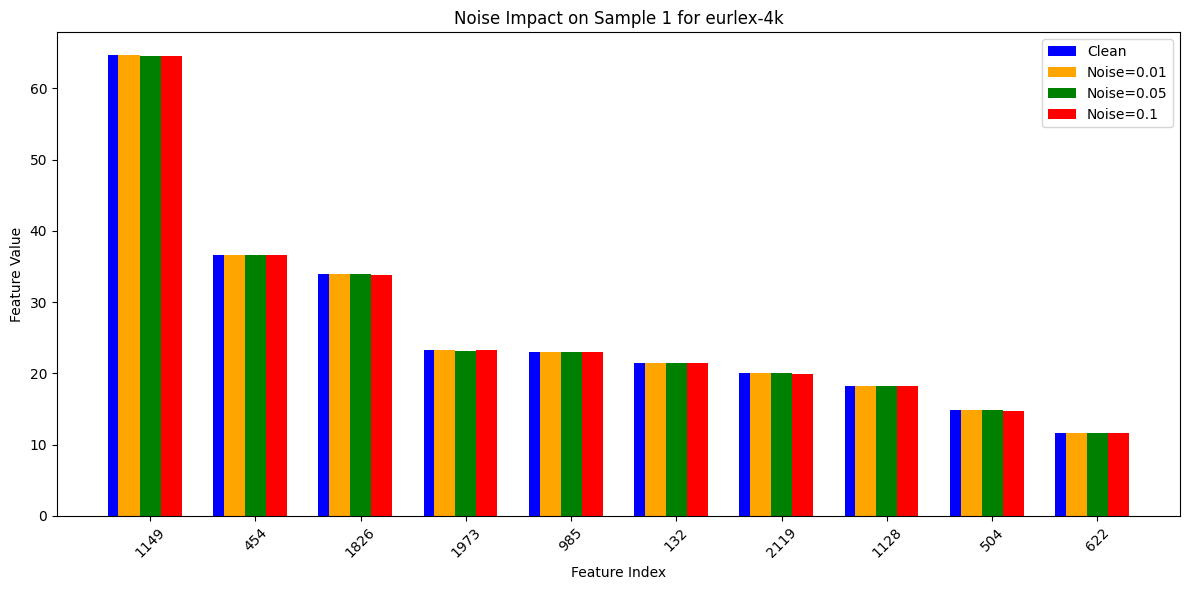

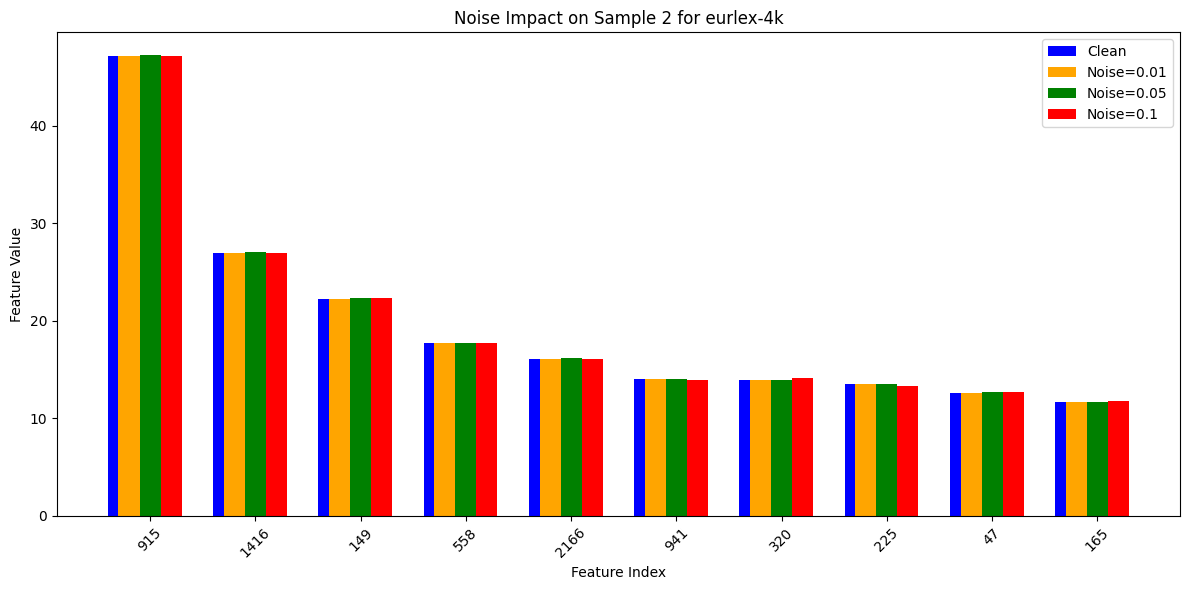

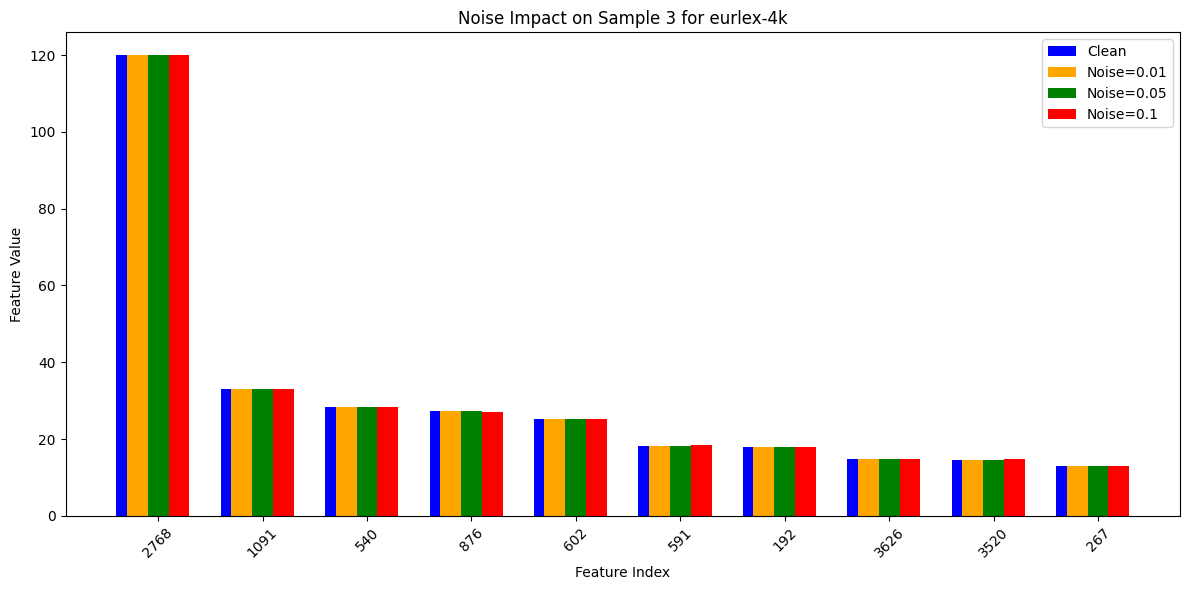


Generating performance plots...


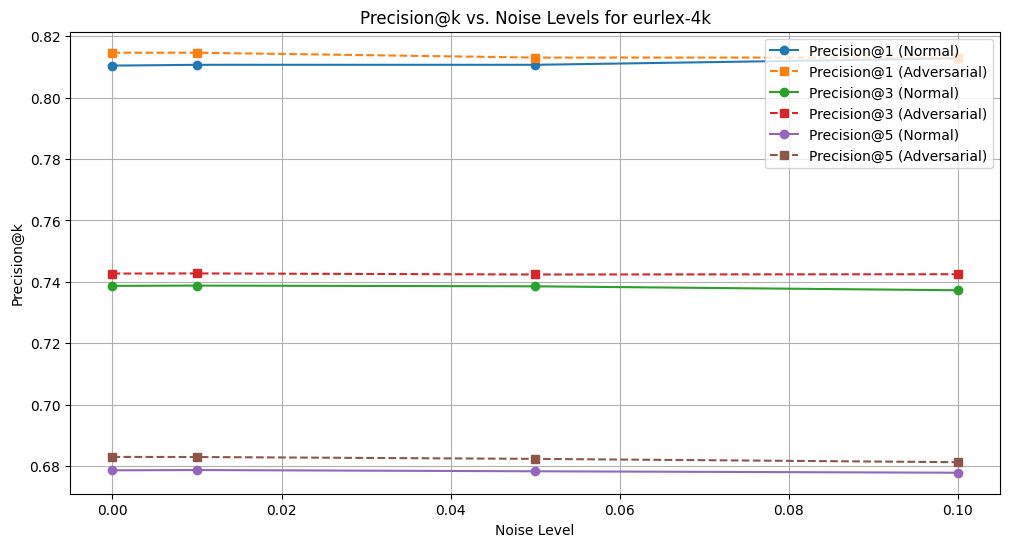

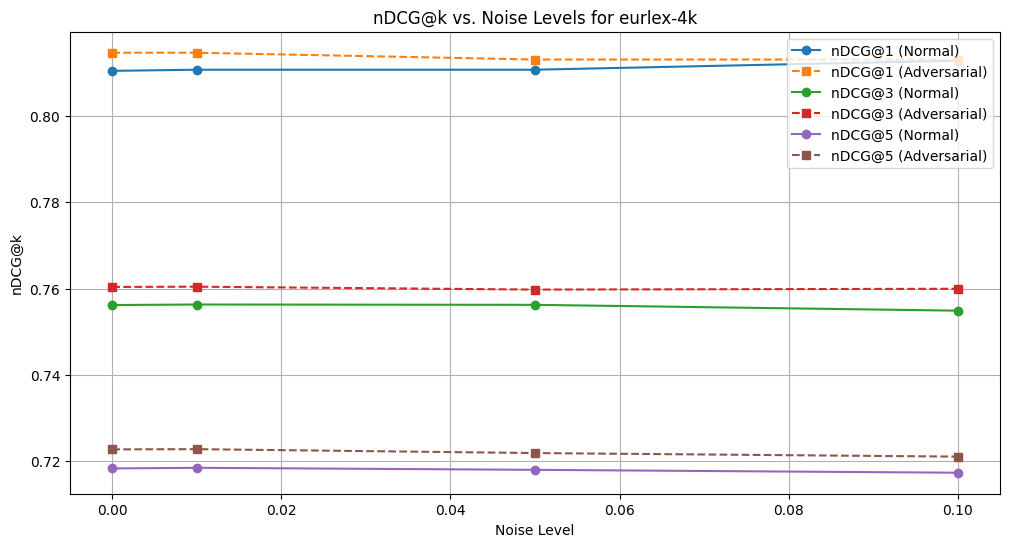

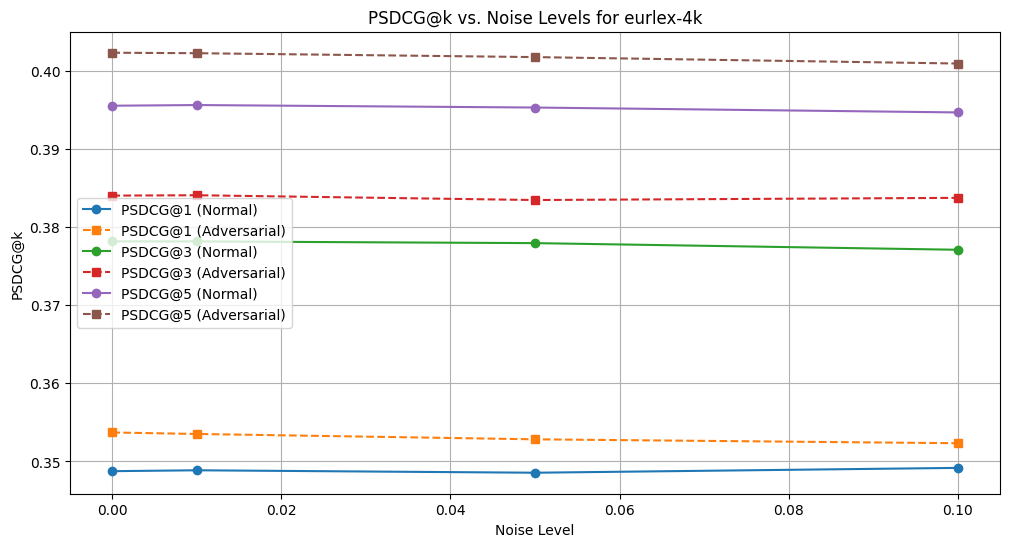


Generating prediction time plots...


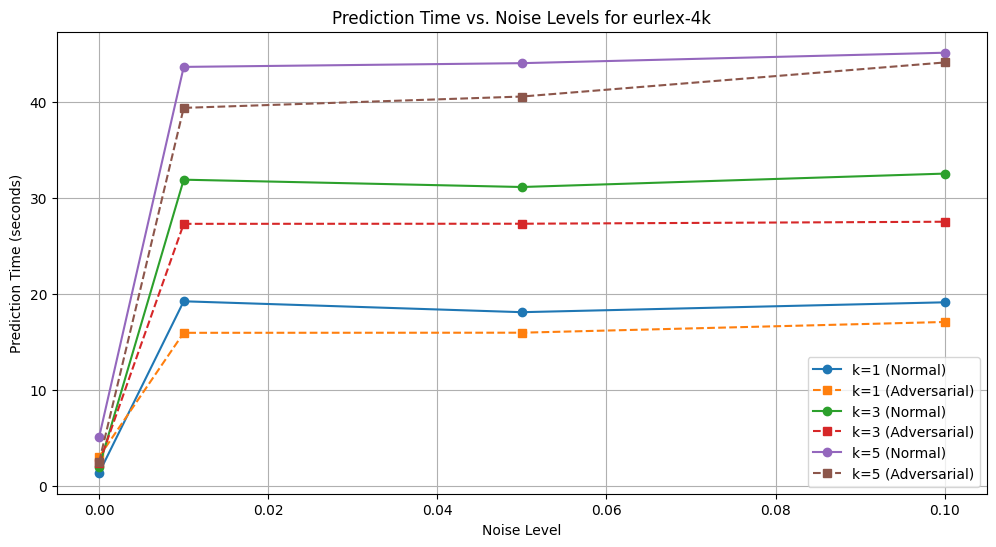


Generating feature importance plots...


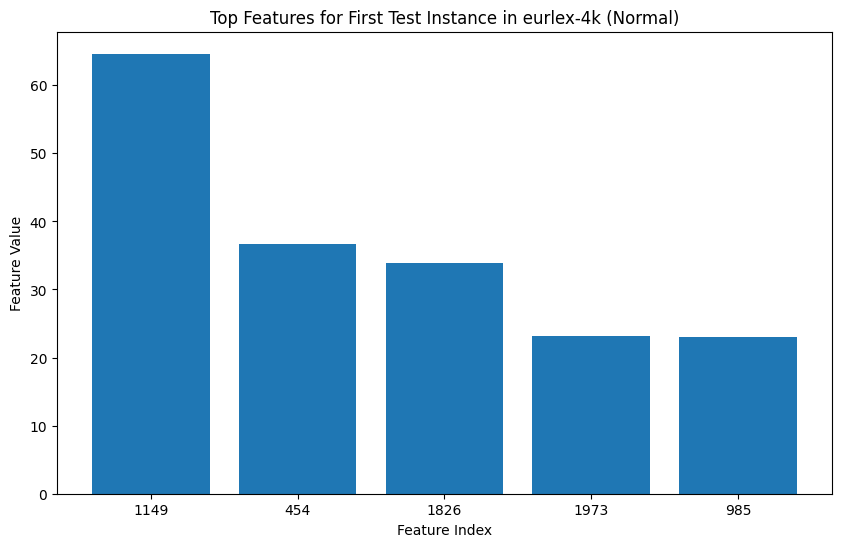

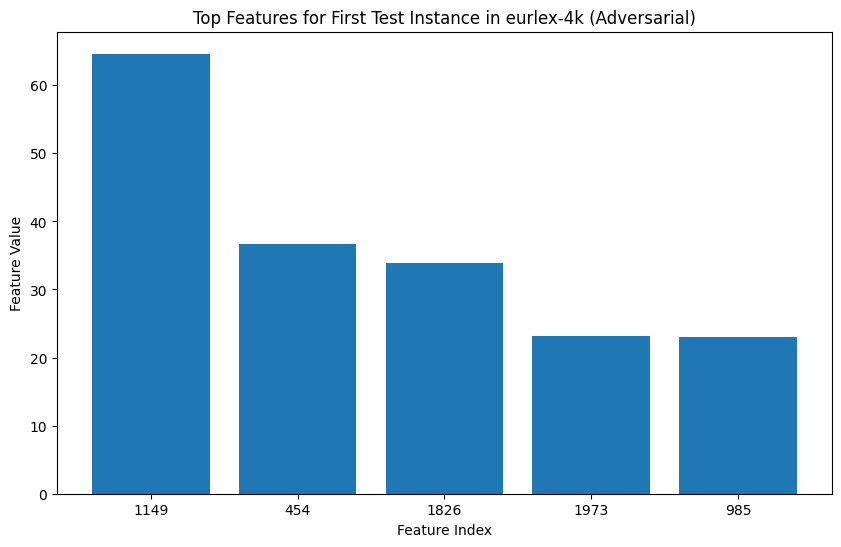


Analysis Summary:

  - For k=1:
    - Normal model: Clean precision@1 is 0.8104.
    - Adversarial model: Clean precision@1 is 0.8146.
    - Noise level 0.01:
      - Normal model: Precision@1 dropped by -0.03%.
      - Adversarial model: Precision@1 dropped by 0.00%.
    - Noise level 0.05:
      - Normal model: Precision@1 dropped by -0.03%.
      - Adversarial model: Precision@1 dropped by 0.19%.
    - Noise level 0.1:
      - Normal model: Precision@1 dropped by -0.29%.
      - Adversarial model: Precision@1 dropped by 0.19%.

  - For k=3:
    - Normal model: Clean precision@3 is 0.7387.
    - Adversarial model: Clean precision@3 is 0.7427.
    - Noise level 0.01:
      - Normal model: Precision@3 dropped by -0.01%.
      - Adversarial model: Precision@3 dropped by -0.01%.
    - Noise level 0.05:
      - Normal model: Precision@3 dropped by 0.02%.
      - Adversarial model: Precision@3 dropped by 0.04%.
    - Noise level 0.1:
      - Normal model: Precision@3 dropped by 0.19%.
   

In [ ]:
run_experiment("eurlex-4k")


Experiment for Dataset: mediamill
Loading data...
Train shape: (30993, 121), Test shape: (12914, 121)
Computing inverse propensity scores...

Starting normal training...
Normal training completed in 25.2727 seconds

Starting adversarial training...
Adversarial training completed in 56.8941 seconds

Predicting on clean test data...

Normal Model:

Baseline Metrics (Clean Data, k=1):
  Precision@1: 0.8210
  nDCG@1:     0.8210
  PSDCG@1:    0.5677
  Prediction Time: 0.2797 seconds

Baseline Metrics (Clean Data, k=3):
  Precision@3: 0.7472
  nDCG@3:     0.7808
  PSDCG@3:    0.5834
  Prediction Time: 0.3739 seconds

Baseline Metrics (Clean Data, k=5):
  Precision@5: 0.6673
  nDCG@5:     0.7506
  PSDCG@5:    0.5842
  Prediction Time: 0.3117 seconds

Adversarial Model:

Baseline Metrics (Clean Data, k=1):
  Precision@1: 0.8120
  nDCG@1:     0.8120
  PSDCG@1:    0.5602
  Prediction Time: 0.1830 seconds

Baseline Metrics (Clean Data, k=3):
  Precision@3: 0.7409
  nDCG@3:     0.7735
  PSDCG@3: 

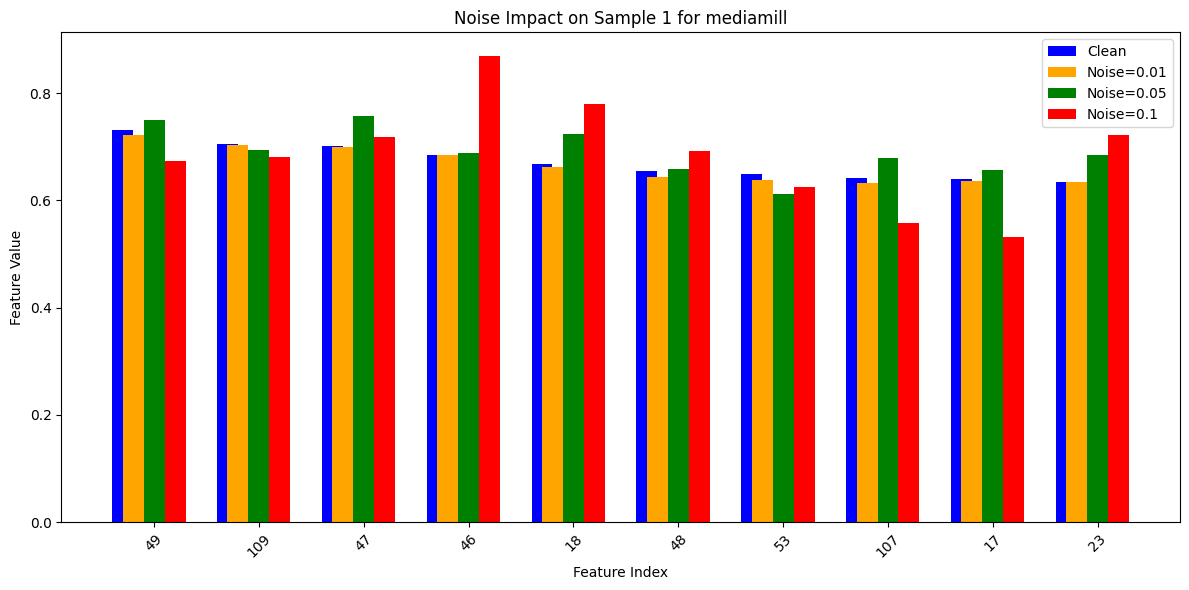

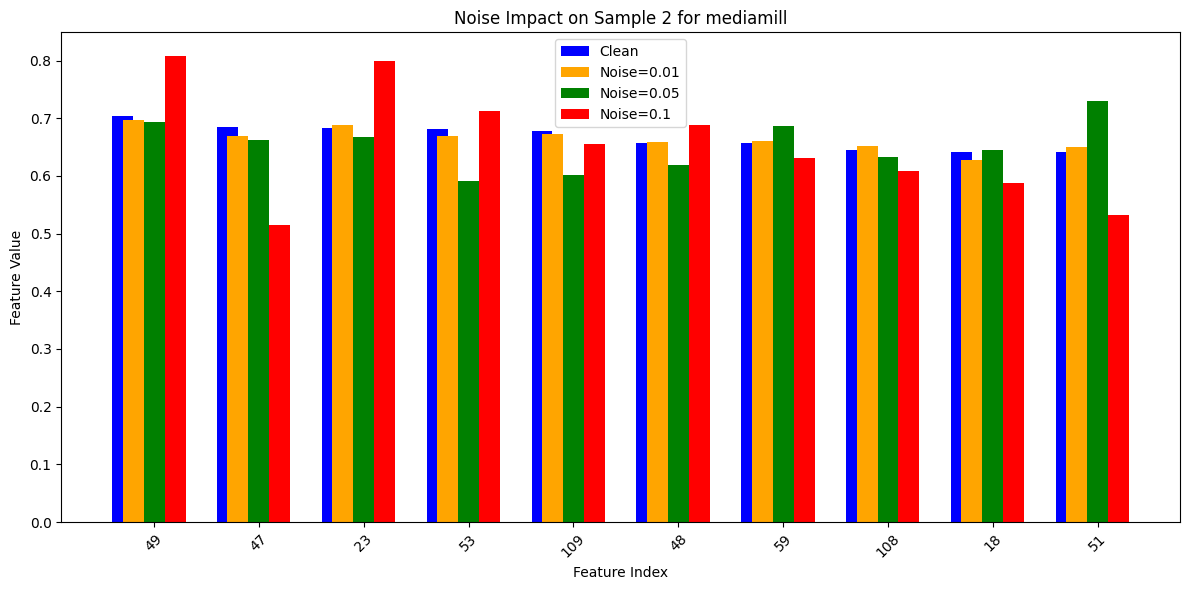

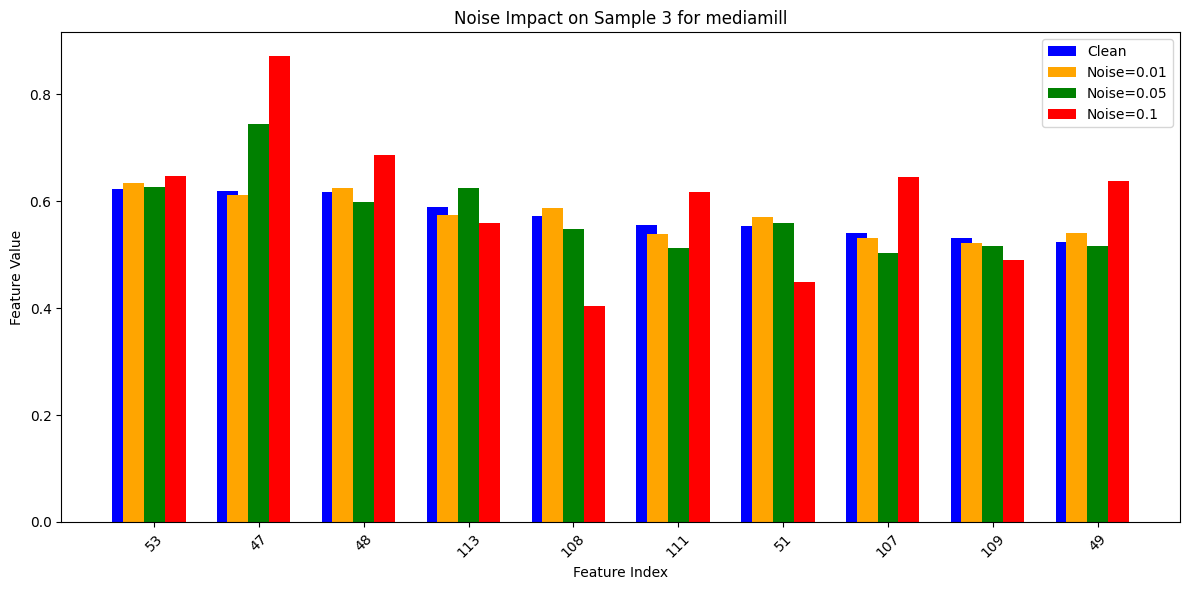


Generating performance plots...


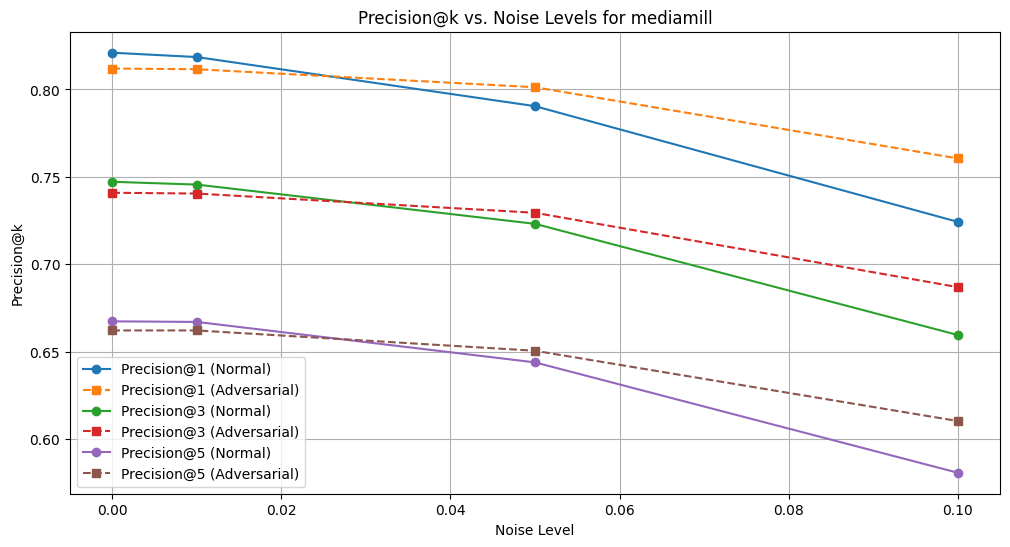

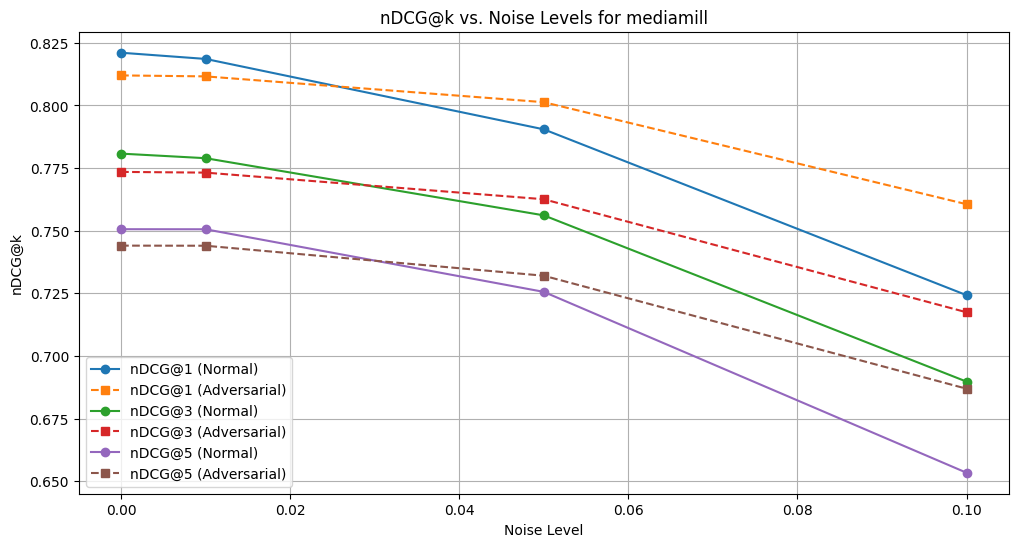

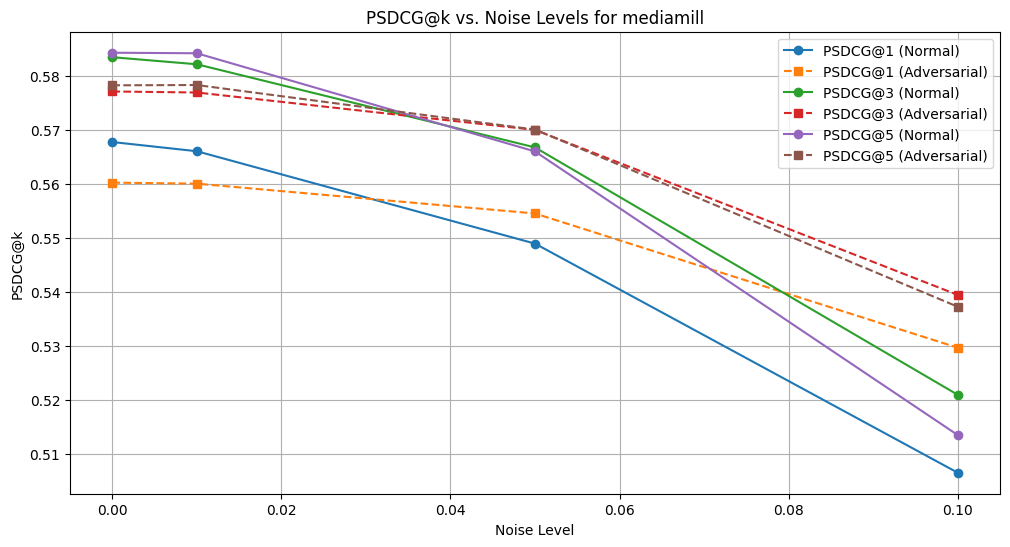


Generating prediction time plots...


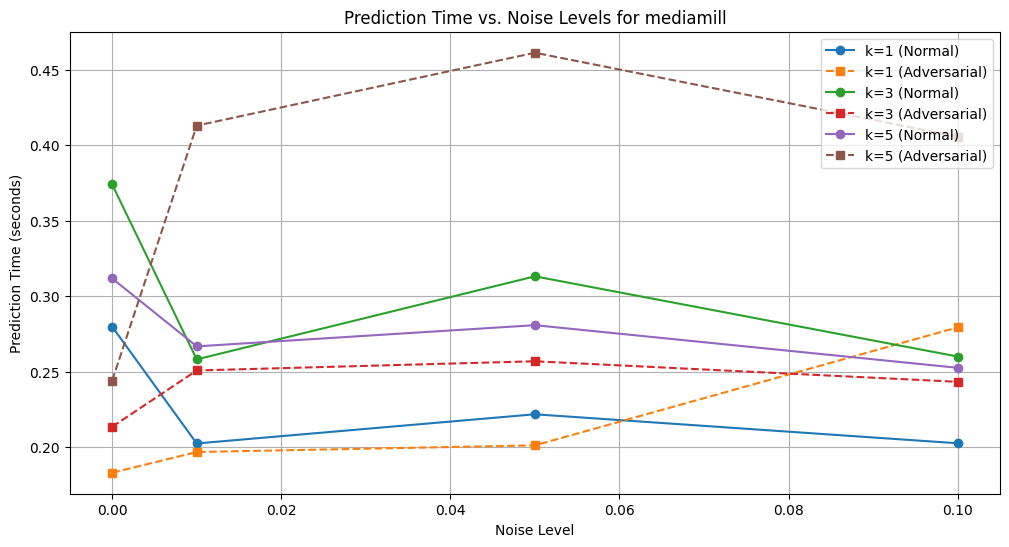


Generating feature importance plots...


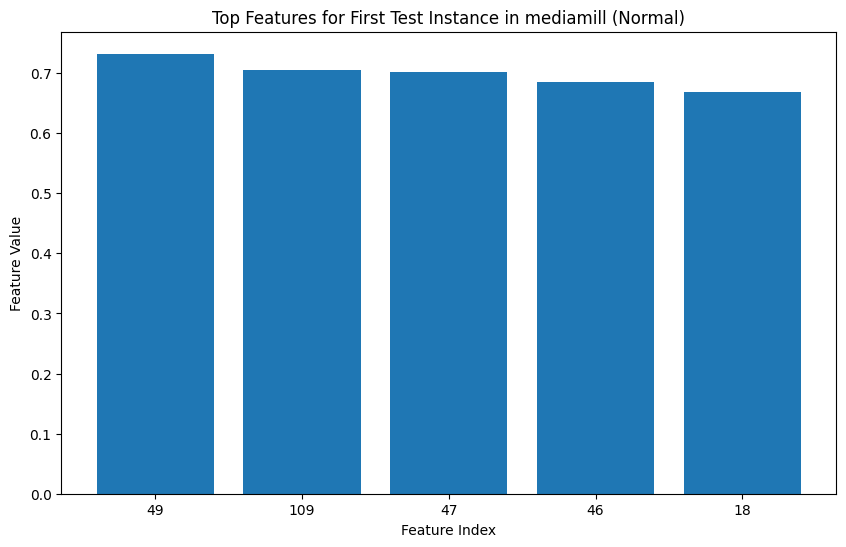

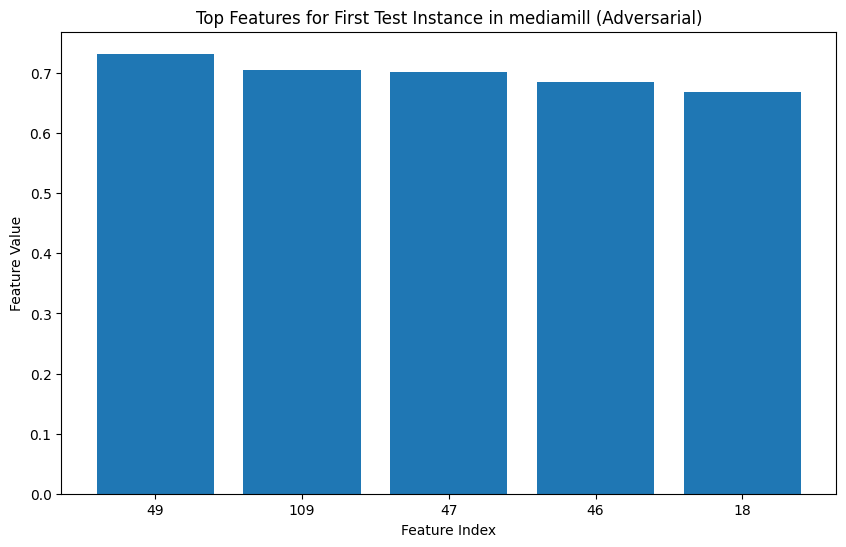


Analysis Summary:

  - For k=1:
    - Normal model: Clean precision@1 is 0.8210.
    - Adversarial model: Clean precision@1 is 0.8120.
    - Noise level 0.01:
      - Normal model: Precision@1 dropped by 0.30%.
      - Adversarial model: Precision@1 dropped by 0.05%.
    - Noise level 0.05:
      - Normal model: Precision@1 dropped by 3.73%.
      - Adversarial model: Precision@1 dropped by 1.32%.
    - Noise level 0.1:
      - Normal model: Precision@1 dropped by 11.79%.
      - Adversarial model: Precision@1 dropped by 6.33%.

  - For k=3:
    - Normal model: Clean precision@3 is 0.7472.
    - Adversarial model: Clean precision@3 is 0.7409.
    - Noise level 0.01:
      - Normal model: Precision@3 dropped by 0.21%.
      - Adversarial model: Precision@3 dropped by 0.06%.
    - Noise level 0.05:
      - Normal model: Precision@3 dropped by 3.22%.
      - Adversarial model: Precision@3 dropped by 1.55%.
    - Noise level 0.1:
      - Normal model: Precision@3 dropped by 11.73%.
      

In [ ]:
run_experiment("mediamill")